In [1]:
import pandas as pd

train = pd.read_csv('../Deep-Learning-project/dataset/training.csv')
test = pd.read_csv('../Deep-Learning-project/dataset/test.csv')
validation = pd.read_csv('../Deep-Learning-project/dataset/validation.csv')

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokenized = word_tokenize(text)  # tokenize text
    cleaned_text = [word for word in tokenized if word not in stopwords.words('english')]  # remove stopwords
    return " ".join(cleaned_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chethanats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chethanats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Assuming the preprocessing function is defined above
train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)
validation['cleaned_text'] = validation['text'].apply(preprocess_text)

labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['emotion'] = train['label'].map(labels_dict)
test['emotion'] = test['label'].map(labels_dict)
validation['emotion'] = validation['label'].map(labels_dict)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_val = tokenizer.texts_to_sequences(validation['cleaned_text'])

# Pad sequences
max_length = max(max(len(x) for x in X_train), max(len(x) for x in X_test), max(len(x) for x in X_val))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

# Encode labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['emotion'])

y_train = encoder.transform(train['emotion'])
y_test = encoder.transform(test['emotion'])
y_val = encoder.transform(validation['emotion'])

In [4]:
test.head(10)

,text,label,cleaned_text,emotion
0,im feeling rather rotten so im not very ambiti...,0,im feeling rather rotten im ambitious right,sad
1,im updating my blog because i feel shitty,0,im updating blog feel shitty,sad
2,i never make her separate from me because i do...,0,never make separate ever want feel like ashamed,sad
3,i left with my bouquet of red and yellow tulip...,1,left bouquet red yellow tulips arm feeling sli...,happy
4,i was feeling a little vain when i did this one,0,feeling little vain one,sad
5,i cant walk into a shop anywhere where i do no...,4,cant walk shop anywhere feel uncomfortable,fear
6,i felt anger when at the end of a telephone call,3,felt anger end telephone call,anger
7,i explain why i clung to a relationship with a...,1,explain clung relationship boy many ways immat...,happy
8,i like to have the same breathless feeling as ...,1,like breathless feeling reader eager see happe...,happy
9,i jest i feel grumpy tired and pre menstrual w...,3,jest feel grumpy tired pre menstrual probably ...,anger


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Parameters 
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 100  # Size of the embedding vectors
lstm_units = 64  # Number of units in the LSTM layer

In [6]:
# Model definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=lstm_units, return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer added to prevent overfitting
model.add(Dense(units=encoder.classes_.size, activation='softmax'))  


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1506300   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1548930 (5.91 MB)
Trainable params: 1548930 (5.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
!pip install pydot
!pip install graphviz

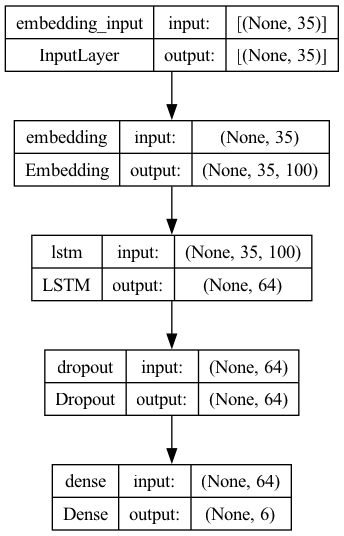

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='LSTM_model_architecture.png', show_shapes=True)

In [12]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [13]:
# Train the model with Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping to training
)

Epoch 1/10
500/500 [==============================] - 12s 23ms/step - loss: 1.5963 - accuracy: 0.3239 - val_loss: 1.5879 - val_accuracy: 0.2750
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 1.2385 - accuracy: 0.4313 - val_loss: 1.0943 - val_accuracy: 0.4735
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 0.8545 - accuracy: 0.6087 - val_loss: 0.7855 - val_accuracy: 0.7350
Epoch 4/10
500/500 [==============================] - 11s 21ms/step - loss: 0.4563 - accuracy: 0.8731 - val_loss: 0.4621 - val_accuracy: 0.8725
Epoch 5/10
500/500 [==============================] - 11s 21ms/step - loss: 0.2482 - accuracy: 0.9317 - val_loss: 0.4005 - val_accuracy: 0.8875
Epoch 6/10
500/500 [==============================] - 11s 21ms/step - loss: 0.1514 - accuracy: 0.9577 - val_loss: 0.3596 - val_accuracy: 0.8995
Epoch 7/10
500/500 [==============================] - 11s 22ms/step - loss: 0.1069 - accuracy: 0.9689 - val_loss: 0.3182 - val_accuracy:

In [14]:
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
    print(f'Epoch {epoch+1}: Loss = {loss}, Accuracy = {acc}')

Epoch 1: Loss = 1.5963270664215088, Accuracy = 0.3238750100135803
Epoch 2: Loss = 1.2384980916976929, Accuracy = 0.4312500059604645
Epoch 3: Loss = 0.8544595241546631, Accuracy = 0.6087499856948853
Epoch 4: Loss = 0.45629557967185974, Accuracy = 0.8730624914169312
Epoch 5: Loss = 0.24821901321411133, Accuracy = 0.9316874742507935
Epoch 6: Loss = 0.15138141810894012, Accuracy = 0.957687497138977
Epoch 7: Loss = 0.10691626369953156, Accuracy = 0.968874990940094
Epoch 8: Loss = 0.08395316451787949, Accuracy = 0.9755625128746033
Epoch 9: Loss = 0.07724107056856155, Accuracy = 0.9774374961853027
Epoch 10: Loss = 0.0713663250207901, Accuracy = 0.9790624976158142


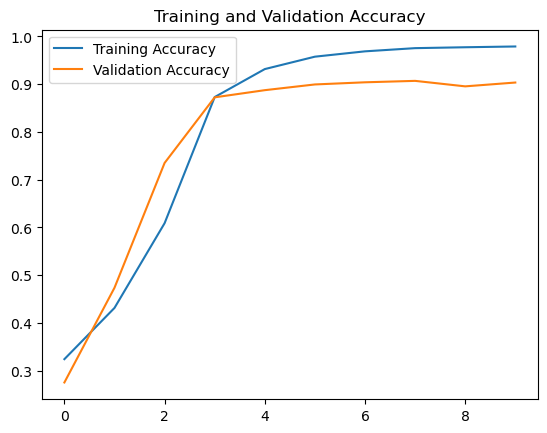

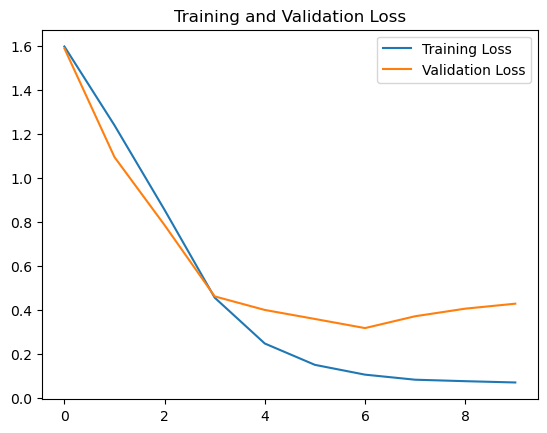

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predict probabilities for the validation set
probabilities = model.predict(X_val)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Assuming y_val is already the array of labels and not one-hot encoded
print("Accuracy for Validation Data - ",accuracy_score(y_val, predictions)*100)
print(classification_report(y_val, predictions))


63/63 [==============================] - 0s 4ms/step
Accuracy for Validation Data -  90.35
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       275
           1       0.87      0.88      0.88       212
           2       0.92      0.92      0.92       704
           3       0.81      0.74      0.77       178
           4       0.94      0.95      0.95       550
           5       0.76      0.78      0.77        81

    accuracy                           0.90      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



In [17]:
# Tokenize the test text data
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode the labels if they are categorical
y_test = encoder.transform(test['emotion'])

# Predict probabilities for the test set
probabilities = model.predict(X_test)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Evaluate the performance of the LSTM model on the test set
test_accuracy = accuracy_score(y_test, predictions)*100
test_report = classification_report(y_test, predictions)

print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Data:\n", test_report)


63/63 [==============================] - 0s 4ms/step
Test Accuracy: 91.3
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       275
           1       0.89      0.93      0.91       224
           2       0.93      0.92      0.93       695
           3       0.77      0.79      0.78       159
           4       0.97      0.95      0.96       581
           5       0.81      0.71      0.76        66

    accuracy                           0.91      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



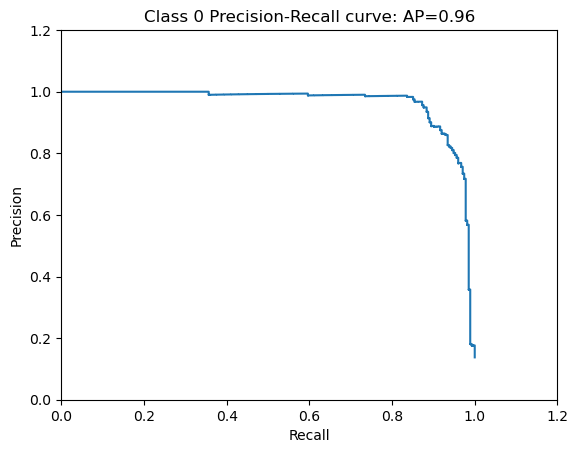

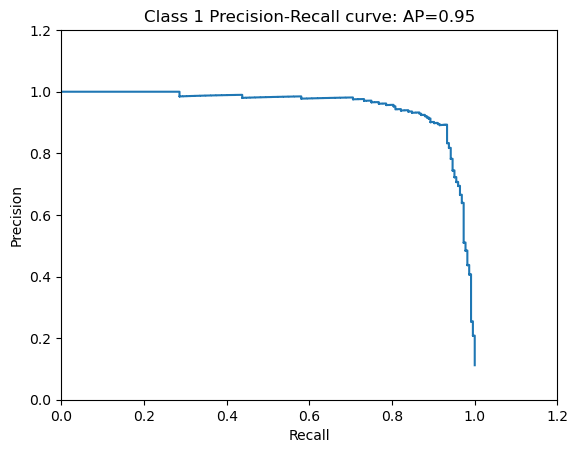

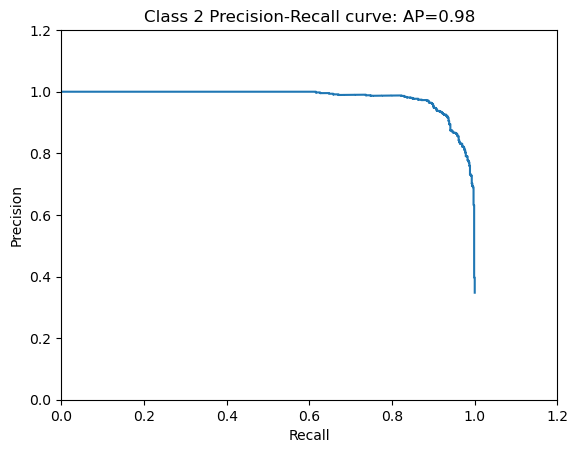

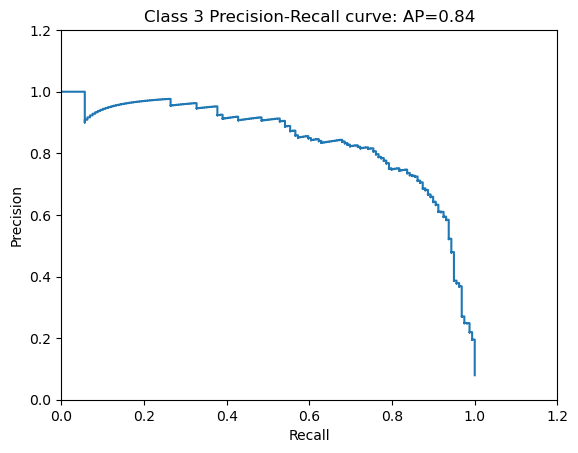

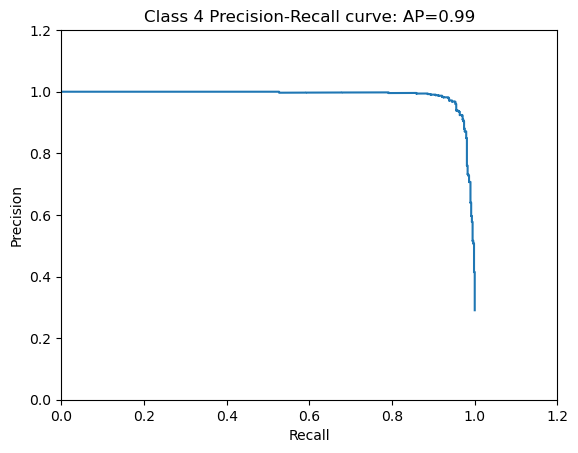

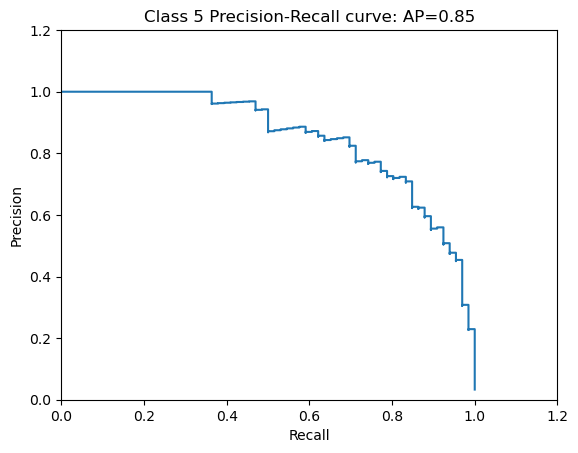

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

n_classes = 6
# Ensure y_test is binarized for each class (one-vs-all approach)
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

precision = dict()
recall = dict()
average_precision = dict()

# Iterate over each class and compute precision-recall curve
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], probabilities[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], probabilities[:, i])

# Now plot the precision-recall curves
for i in range(n_classes):
    plt.figure()
    plt.step(recall[i], precision[i], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.2])
    plt.xlim([0.0, 1.2])
    plt.tight_layout
    plt.title(f'Class {i} Precision-Recall curve: AP={average_precision[i]:0.2f}')
    plt.show()

labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

1. Class 0 - AP: 0.97: The model is excellent at identifying class 0. It can distinguish class 0 instances from instances of other classes with high precision across different recall levels.

2. Class 1 - AP: 0.93: The model is also performing well on class 1, though not as well as class 0. It may occasionally confuse class 1 with other classes or vice versa.

3. Class 2 - AP: 0.99: The model performs exceptionally well on class 2, similar to class 0. It is very good at classifying instances of class 2 correctly.

4. Class 3 - AP: 0.87: This score is lower compared to others, indicating that the model has more difficulty correctly identifying class 3, especially when it tries to increase its recall.

5. Class 4 - AP: 0.99: Like classes 0 and 2, class 4 is also identified with high precision and recall. The model is highly confident and accurate in distinguishing these instances.

6. Class 5 - AP: 0.76: This is the lowest AP score among all the classes, suggesting the model struggles the most with class 5. This could be due to class 5 instances being more similar to other classes, or it could be less represented in the training data.

In [21]:
unique_counts = train['emotion'].value_counts()
unique_counts

emotion
happy       5362
sad         4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [26]:
def predict_emotion(text):
    # Preprocess and tokenize the input text
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    # Pad the sequence
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    # Perform the prediction
    prediction = model.predict(padded_seq)
    # Decode the prediction
    label_idx = prediction.argmax(axis=1)[0]
    return encoder.inverse_transform([label_idx])[0]

# Example usage
input_text = input("Enter some sentence:")
predict_emotion(input_text)


Enter some sentence:i love deep learning
1/1 [==============================] - 0s 17ms/step


'happy'